# Thesis Predecessor V3
Now with Uniform Distributions!

In [1]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import metrics
from keras import regularizers
from keras.layers import Dense, Activation, Input, Dropout, BatchNormalization
from keras.models import Sequential
from keras_tqdm import TQDMNotebookCallback as ktqdm
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.distributions.empirical_distribution import ECDF
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix

Using TensorFlow backend.


## Reproducibility

1) Definire la struttura dei dati di input
    N interi ordinati
2) Ad ogni predecessore è associato un F(x)
    Calcolare tale F per ogni predecessore
    Dividere i predecessori in Training e Testing
3) Dare in pasto alla rete il training ed il testing
    Il numero risultante, F(x) viene moltiplicato per le dimensioni di Training Set.
    Il numero ottenuto, arrotondato alla cifra successiva, moltiplicato, è il predecessore del numero datoin pasto alla rete.

In [2]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(42)
random.seed(42)
tf.set_random_seed(42)

## Creation of uniform distribution
First comes the distribution of predecessors.
Then we create the cumulative of the predecessors.
So we generate a testing set from 1 to size * step.
At last we create an array where every cumulative is cumulative[i] repeated step times

In [3]:
step = 50
size = 10000
n = step * size
width = np.ceil(np.log2(n)).astype(int)
predecessors = np.arange(0, n, step)
predecessors = np.array([
    (predecessors[i]) for i in range(size)
]).astype(int)
predecessors, predecessors.shape

(array([     0,     50,    100, ..., 499850, 499900, 499950]), (10000,))

In [4]:
cumulative_predecessors = np.array([(((i / size))) for i in range(size)])
#cumulative_predecessors = np.array([(((i / size) * 2) - 1) for i in range(size)])

cumulative_predecessors, cumulative_predecessors.size

(array([0.000e+00, 1.000e-04, 2.000e-04, ..., 9.997e-01, 9.998e-01,
        9.999e-01]), 10000)

 ## Bit conversion in digits of predecessors

In [5]:
predecessors = np.array([
    list(np.binary_repr(i, width)) for i in np.arange(0, n, step)
]).astype(int)
np.set_printoptions(threshold=100)
predecessors, predecessors.shape

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 1, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 1, 0],
        [1, 1, 1, ..., 1, 0, 0],
        [1, 1, 1, ..., 1, 1, 0]]), (10000, 19))

## Create set of training + testing
Join the four sets created, shuffle them and resplit them

In [6]:
x_train, x_test, y_train, y_test = train_test_split(
    predecessors, 
    cumulative_predecessors, 
    test_size=0.25, 
    random_state=42)

In [7]:
x_train.shape, y_train.shape

((7500, 19), (7500,))

In [8]:
x_test.shape, y_test.shape

((2500, 19), (2500,))

## Network Metrics

In [9]:
def plot_history_graph(history, index, label):
    """Plot the graph for the given history metrics."""
    plt.plot(history.history[index], label='Training %s = %0.6f' % (label, history.history[index][-1]))
    plt.plot(history.history['val_%s'%index] , label='Testing %s = %0.6f' % (label, history.history['val_%s'%index][-1]))
    plt.title('Model %s'%label, fontsize=15)
    plt.ylabel(label)
    plt.xlabel('epoch')
    plt.legend(loc='upper right')
    plt.figure(figsize=(40,20))

## Definition of Custom Sigmoid Function

In [10]:
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

beta1 = 1
beta0 = 0.5
beta2 = 2

def custom_activation(x):
    return (K.sigmoid(x * 3))

def custom_activation_std(x):
    return (K.sigmoid(x))

## Define function to build the model

In [11]:
def build_model(neurons):
    """ Return keras network model """
    model = Sequential()
    model.add(Dense(int(neurons * 3), input_dim=neurons, name="Input_dense_layer", activation="sigmoid"))
    #model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(int(neurons * 2), name="Dense_layer_2", activation="sigmoid"))
    model.add(BatchNormalization())
    model.add(Dense(1, name="Output_dense_layer", activation="sigmoid"))
    model.compile(
        loss='mean_squared_error', optimizer='sgd', metrics=['mean_absolute_error'])

    return model

#Con un primo strato nascosto di dimensione neurons * 3 
#ed un secondo di dimensione neurons * 2 si ottengono ottimi risultati

## Construction of the model

In [12]:
from keras.utils import plot_model

model = build_model(width)
model.summary()
plot_model(model, to_file="net_model_starting_point.png")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_dense_layer (Dense)    (None, 57)                1140      
_________________________________________________________________
batch_normalization_1 (Batch (None, 57)                228       
_________________________________________________________________
Dense_layer_2 (Dense)        (None, 38)                2204      
_________________________________________________________________
batch_normalization_2 (Batch (None, 38)                152       
_________________________________________________________________
Output_dense_layer (Dense)   (None, 1)                 39        
Total params: 3,763
Trainable params: 3,573
Non-trainable params: 190
_________________________________________________________________


In [13]:
history = model.fit(
    x_train, 
    y_train,
    epochs=100,
    shuffle=True,
    batch_size=256,
    verbose=0,
    callbacks=[ktqdm(metric_format="{name}: {value:e}")],
    validation_data=(x_test, y_test)
)

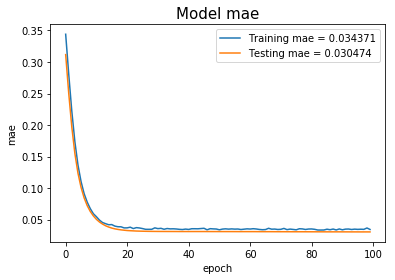

<Figure size 2880x1440 with 0 Axes>

In [14]:
plot_history_graph(history, 'mean_absolute_error', 'mae')

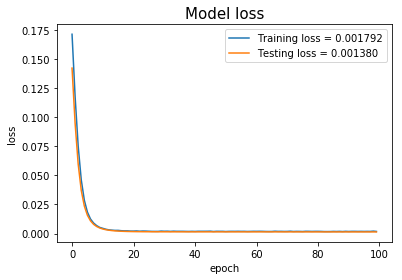

<Figure size 2880x1440 with 0 Axes>

In [15]:
plot_history_graph(history, 'loss', 'loss')

In [16]:
def prediction(num, width, model):
    bin = np.array([list(np.binary_repr(num, width))])
    print("Prediction on ", num, ":\t ", model.predict(bin))

(prediction(int(1), width, model)), (prediction(int(50 * 10001), width, model))

Prediction on  1 :	  [[0.04012125]]
Prediction on  500050 :	  [[0.9235834]]


(None, None)